In [1]:
import pandas as pd
from scipy.io import mmread
import scanpy as sc
import os
import sys
sys.path.append(os.path.abspath('../../'))
import ScATACAnnotater.SortedNoDupeBedOverlap as bdO
from ScATACAnnotater import io_utils
from ScATACAnnotater import stats_utils

/hpc/users/leeh36/miniconda3/lib/python3.8/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [20]:
mat = mmread('filtered_peak_bc_matrix/matrix.mtx')

In [21]:
mat = mat.toarray().T

In [6]:
id2bc = pd.read_csv('filtered_peak_bc_matrix/barcodes.tsv', header = None)[0].values
id2peak = io_utils.read_bed_file('filtered_peak_bc_matrix/peaks.bed')

In [7]:
#id2bc = id2bc[::10]

In [8]:
df_peak = pd.read_csv('filtered_peak_bc_matrix/peaks.bed', header = None, sep = '\t')

In [9]:
len(id2peak)

74633

In [11]:
ref_subtype_peaks0, ref_bk_peak = io_utils.read_reference_data('../../data/GSE97887/', verbose = False)

In [12]:
len(ref_subtype_peaks[1][1])

NameError: name 'ref_subtype_peaks' is not defined

In [13]:
intersect = set(bdO.BedOverlap(id2peak, sorted(ref_bk_peak), 50))

ref_subtype_peaks = []
for c, peaks in ref_subtype_peaks0:
    ref_subtype_peaks.append( (c, set(bdO.BedOverlap(id2peak, sorted(peaks), 50))) )

In [14]:
for c, peaks in ref_subtype_peaks:
    print(c, len(peaks))

Ast 1749
End 428
Ex 5451
In 1719
Oli 3511
Opc 1722


In [22]:
mat.shape, len(id2peak)

((36286, 74633), 74633)

In [23]:
scores = stats_utils.compute_enrichment_score(mat, intersect, id2peak, ref_subtype_peaks, num_cores = 10)

... storing 0 as categorical


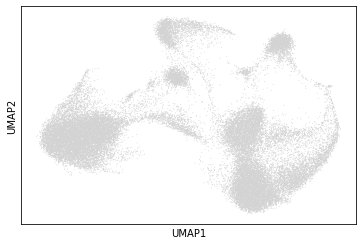

In [24]:
data_obj = sc.AnnData(mat, 
          obs = pd.DataFrame([], index = id2bc),
          var = df_peak,
          )

sc.pp.normalize_total(data_obj)
sc.pp.pca(data_obj, n_comps=50)
sc.pp.neighbors(data_obj)
sc.tl.umap(data_obj)

sc.pl.umap(data_obj)

In [25]:
score_df = pd.DataFrame(scores, 
                        columns = [c for c, _ in ref_subtype_peaks],
                       index = data_obj.obs.index
                       )

In [26]:
score_df.head()

,Ast,End,Ex,In,Oli,Opc
AAACGAAAGAATACTG-4,0.539136,0.900738,1.850057,1.144115,0.368345,0.420115
AAACGAAAGACTAATG-4,2.480414,2.283385,0.430096,0.000000,0.623563,2.938946
AAACGAAAGAGAGTAG-1,1.211019,5.440282,0.298476,0.122288,0.823156,1.232163
AAACGAAAGAGCTGTG-3,4.147535,0.291151,0.355513,0.720166,1.416518,2.804104
AAACGAAAGAGGAATG-5,0.639319,0.854963,1.583814,1.246130,0.628325,0.725263


In [27]:
data_obj.obs = score_df

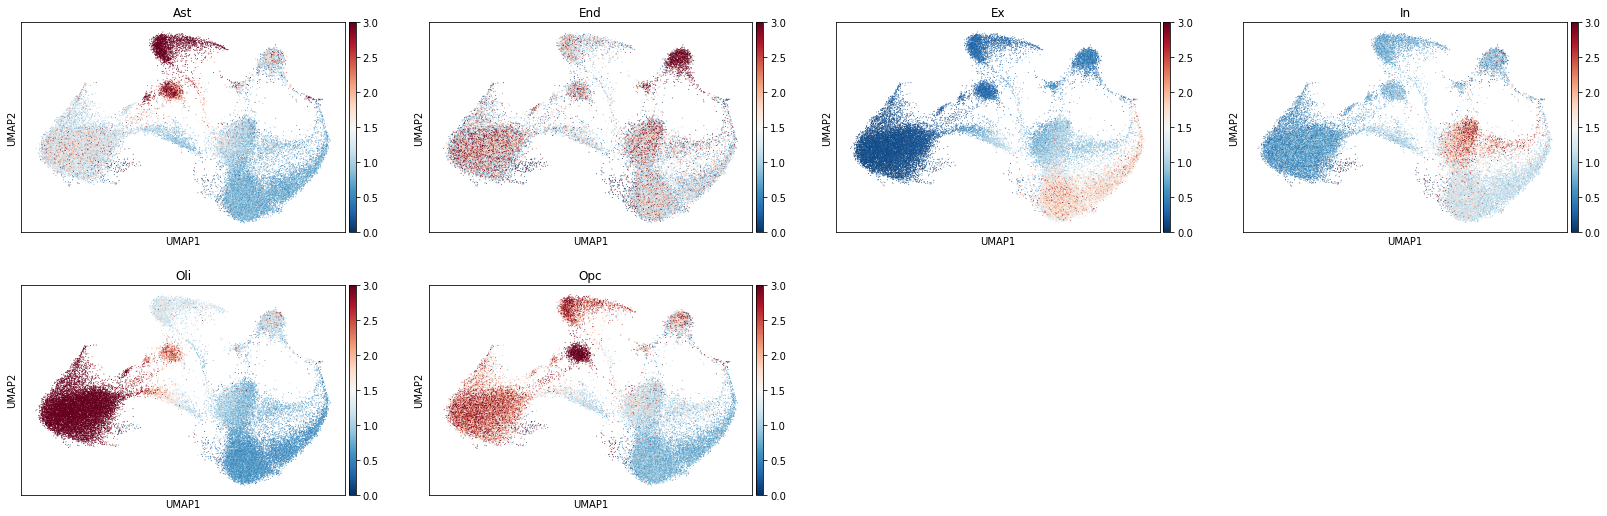

In [28]:
sc.pl.umap(data_obj, color = score_df.columns, cmap = 'RdBu_r', vmax = 3)

In [34]:
df_tsne = pd.read_csv('/hpc/users/leeh36/CommonMind/cellranger/AGG_scATAC/outs/analysis/tsne/2_components/projection.csv', index_col = 0)

In [36]:
df_tsne

,TSNE-1,TSNE-2
Barcode,,
AAACGAAAGAATACTG-4,-14.954779,-19.009070
AAACGAAAGACTAATG-4,-13.373275,26.075277
AAACGAAAGAGAGTAG-1,-14.465274,31.261123
AAACGAAAGAGCTGTG-3,19.633750,-12.986285
AAACGAAAGAGGAATG-5,-23.173967,-18.864300
...,...,...
TTTGTGTTCGTGTGCG-4,1.128383,3.742230
TTTGTGTTCTAGTCGA-3,1.998126,-19.999804
TTTGTGTTCTGACATG-4,23.752089,-13.811954


In [40]:
data_obj.obsm['X_tsne'] = df_tsne.values

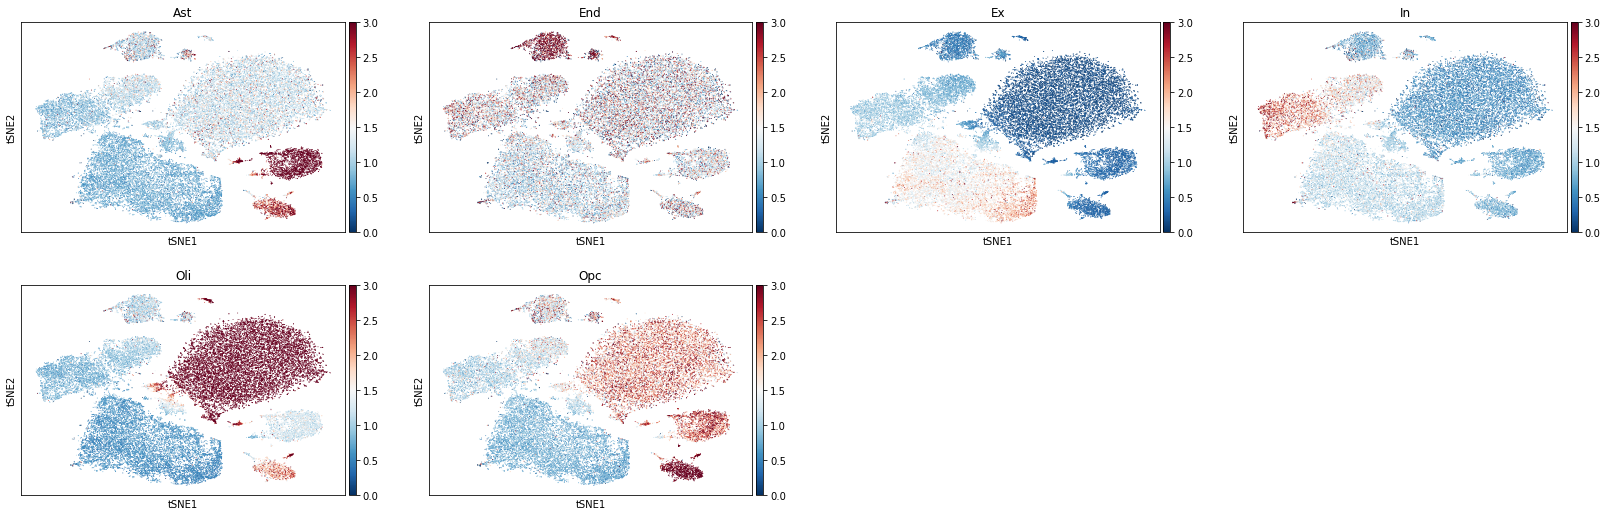

In [41]:
sc.pl.tsne(data_obj, color = score_df.columns, cmap = 'RdBu_r', vmax = 3)